In [1]:
import pandas as pd
import numpy as np
import random
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.environ import SolverFactory
import yfinance as yf
import matplotlib.pyplot as plt

## MODELO DE OTIMIZAÇÂO ROBUSTA em DUAS ETAPAS / Hierarquica



In [29]:
df_ativos=pd.read_csv('..//base_dados//retornos_ativos2.csv').set_index(['Date'])
df_ibov=pd.read_csv('..//base_dados//retorno_ibov2.csv').set_index(['Date']).dropna()

###  a ideia é, df de 12 meses, 2 meses finais para projecao
### sobram 10 meses, 5 para primeira otimização, 5 para a segunda

In [30]:
print("tamanho df_ativo: ",df_ativos.shape)
print("tamanho df_ibov: ",df_ibov.shape)

limite_20 = np.int32(len(df_ativos)*0.20)
resultado_80 = np.int32(len(df_ativos)) - limite_20

df_trabalho_ativo = df_ativos[0:resultado_80]
print("df de trabalho no tamanho de: ", len(df_trabalho_ativo))
df_projecao_final = df_ativos[len(df_trabalho_ativo):]
print("df_projecao_final no tamanho de: ", len(df_projecao_final))

df_trabalho_ibov = df_ibov[0:resultado_80]
df_projecao_final_ibov = df_ibov[len(df_trabalho_ibov):]
print("df_projecao_final_ibov no tamanho de: ", len(df_projecao_final))

metade = np.int32(len(df_trabalho_ativo)/2)




tamanho df_ativo:  (248, 85)
tamanho df_ibov:  (248, 1)
df de trabalho no tamanho de:  199
df_projecao_final no tamanho de:  49
df_projecao_final_ibov no tamanho de:  49


In [4]:
# limite = np.int32(len(df_ativos) / 5 * 4)

retornos_ativo_treino = df_trabalho_ativo[0:metade]
# retornos_ativo_projecao = df_ativos[limite_60:]
retornos_ibov_treino = df_trabalho_ibov[0:metade]
# retornos_ibov_projecao = df_ibov[limite_60:]
print("Shape Ativo Treino: ",retornos_ativo_treino.shape)
# print("Shape Ativo Projeção: ",retornos_ativo_projecao_1.shape)
print("Shape Ativo Treino: ",retornos_ibov_treino.shape)
# print("Shape Ativo Projeção: ",retornos_ibov_projecao_1.shape)


#------------ PARA SEGUNDA ETAPA

retornos_ativo_segunda_etapa = df_trabalho_ativo[metade:]
retornos_ibov_segunda_etapa = df_trabalho_ibov[metade:]

print('-----------')
print("Shape Ativo 2º Treino: ",retornos_ativo_segunda_etapa.shape)
print("Shape Ibov 2º Treino: ",retornos_ibov_segunda_etapa.shape)


Shape Ativo Treino:  (99, 85)
Shape Ativo Treino:  (99, 1)
-----------
Shape Ativo 2º Treino:  (100, 85)
Shape Ibov 2º Treino:  (100, 1)


In [5]:
retornos_ativo_treino.fillna(0, inplace=True)

C:\Users\DECIV\AppData\Local\Temp\ipykernel_8540\882124678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retornos_ativo_treino.fillna(0, inplace=True)


In [6]:
dicio_ativos = {}
for t in range(len(retornos_ativo_treino)):
    for a in range(len(retornos_ativo_treino.columns)):
        dicio_ativos[t,a] = retornos_ativo_treino.iloc[t,a]

dicio_ibov = {}
for t in range(len(retornos_ibov_treino)):
    dicio_ibov[t] = retornos_ibov_treino['IBOV'].iloc[t]



In [7]:
std_ativos = retornos_ativo_treino.std()
std_ativos = pd.DataFrame(std_ativos, columns=['desvio_padrao'])
dicio_std = {}
for a in range(len(retornos_ativo_treino.columns)):
    dicio_std[a] = std_ativos['desvio_padrao'].iloc[a]


## INICIAR MODELO

In [8]:
model = pyo.ConcreteModel()

# RANGE SET
model.A = pyo.RangeSet(0,len(retornos_ativo_treino.columns)-1)
model.T = pyo.RangeSet(0, len(retornos_ativo_treino)-1)

# PARAMETROS----------------------
model.ATIVOS = pyo.Param(model.T,model.A, initialize=dicio_ativos)
model.IBOV = pyo.Param(model.T, initialize=dicio_ibov)
model.DELTA = pyo.Param(model.A, initialize = dicio_std)
    ##----------------- GAMA: Orçamento de Incerteza -> Defini quantos ativos podem variar ao mesmo tempo (Seguro geral)
        ##  ------ mutable = True -> define parâmetros que podem ser alterados entre execuções de otimização sem reconstruir o modelo
            ##----model.GAMA = 2.0  # Forma simples  OU model.GAMA.store(2.0)
model.GAMA = pyo.Param(initialize = 5.0, mutable = True)
model.QUANTIDADE_ATIVOS = pyo.Param(initialize = 20.0)

# VARIAVEIS----------------------
model.x = pyo.Var(model.A, bounds=(0,1))
model.y = pyo.Var(model.A, within=pyo.Binary)
    ## Para cada dia $t$, o modelo precisa de variáveis extras para "absorver" a incerteza: z[t]: Uma variável global de proteção para o dia $t$. p[t, a]: Uma variável de proteção específica para cada ativo no dia $t$.
model.z = pyo.Var(model.T, bounds=(0,None))
model.p = pyo.Var(model.T, model.A, bounds=(0,None))

    #Capturar erro absoluto de cada dia
model.erro = pyo.Var(model.T, bounds=(0,None))

##------------ ALTERAÇÂO DE MSE para MAD 
def erro_pos(model, t):
    return model.erro[t] >= sum(model.ATIVOS[t,a] * model.x[a] for a in model.A) - model.IBOV[t]
def erro_neg(model, t):
    return model.erro[t] >= -(sum(model.ATIVOS[t,a] * model.x[a] for a in model.A) - model.IBOV[t])

model.con_erro_post = pyo.Constraint(model.T, rule=erro_pos)
model.con_erro_neg = pyo.Constraint(model.T, rule=erro_neg)
controle_peso_da_protecao = 0.1
# controle_peso_da_protecao = 1

# OBJETIVO----------------------
def func_objetivo_1(model):
    mad = sum(model.erro[t] for t in model.T)
    
    ## Termo de proteção Robusta -----------
    protecao = sum(
        (model.GAMA * model.z[t] + sum(model.p[t,a] for a in model.A)) for t in model.T
    )

    

    return mad + controle_peso_da_protecao*protecao

model.obj = pyo.Objective(rule=func_objetivo_1,sense=pyo.minimize)



In [9]:
# RESTRICOES ----------------------
    ## - Ela diz que a proteção deve ser maior ou igual ao impacto do desvio padrão no peso do ativo
def regra_protecao(model,t,a):
    
    return model.z[t] + model.p[t,a] >= model.DELTA[a] * model.x[a]

model.con_protecao = pyo.Constraint(model.T,model.A, rule=regra_protecao)

    ## OUTRAS RESTRIÇÔES

    # 1- Cardinalidade (total ativos na carteira)
def cardinalidade(model):

    return sum(
        model.y[a] for a in model.A
    ) <= model.QUANTIDADE_ATIVOS
model.cardinalidade = pyo.Constraint(rule=cardinalidade)

    # 2 - Soma peso da carteira
def soma_peso_1(model):
    return sum(model.x[a] for a in model.A) == 1
model.soma_peso_1 = pyo.Constraint(rule=soma_peso_1)

    # 3 - x só ativa se y=1
def restr_vinculo_x_y(model, a):

    return model.x[a] <= model.y[a]

model.restr_vinculo_x_y = pyo.Constraint(model.A, rule=restr_vinculo_x_y)

    # Retrição de Peso mínimo, se y=1, x deve ser pelo menos 1%
def peso_min(model, a):
    return model.x[a] >= 0.01 * model.y[a]
model.peso_min = pyo.Constraint(model.A, rule=peso_min)




In [10]:
# Antes do solve, dê uma solução inicial ao CPLEX
for a in model.A:
    model.x[a].value = 1/20  # Peso igual para 20 ativos
    model.y[a].value = 1 if a < 20 else 0

In [11]:
opt = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
opt.options['TimeLimit'] = 300 
# resultado = opt.solve(model)
# opt.options['optimalitytarget'] = 3 ## PARA CASO DE MODELOS NAO LINEARES
opt.options['mip tolerances absmipgap'] = 0.01 
opt.options['mip tolerances mipgap'] = 0.01 
opt.options['mipgap'] = 0.01 

results = opt.solve(model, tee=True, warmstart=True)
print("-------FIM----------")



Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\DECIV\AppData\Local\Temp\tmpnhcloyha.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> New value for time limit in seconds: 300
CPLEX> New value for absolute mixed integer optimality gap tolerance: 0.01
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> Problem 'C:\Users\DECIV\AppData\Local\Temp\tmpgoi9nsq3.pyomo.lp' read.
Read time = 0.02 sec. (1.15 ticks)
CPLEX> MIP start file 'C:\Users\DECIV\AppData\Local\Temp\tmppx_1__lz.cplex.mst' read.
CPLEX> Problem name         : C:\Users\DECIV\AppData\Local\Temp\tmpgoi9nsq3.pyomo.l

          peso_ativo  ativado
VALE3.SA    0.060270      1.0
ITUB4.SA    0.103846      1.0
PETR4.SA    0.058657      1.0
PETR3.SA    0.041075      1.0
AXIA3.SA    0.065223      1.0
SBSP3.SA    0.064740      1.0
B3SA3.SA    0.040195      1.0
WEGE3.SA    0.048145      1.0
BBAS3.SA    0.058731      1.0
ABEV3.SA    0.036522      1.0
RENT3.SA    0.039540      1.0
RADL3.SA    0.012115      1.0
BBDC3.SA    0.053261      1.0
GGBR4.SA    0.042873      1.0
CMIG4.SA    0.046076      1.0
TOTS3.SA    0.056564      1.0
SMFT3.SA    0.037714      1.0
BRAP4.SA    0.066220      1.0
DIRR3.SA    0.035263      1.0
RECV3.SA    0.032971      1.0
106.74986268104769
105.84055633681272
106.3946658199716


C:\Users\DECIV\AppData\Local\Temp\ipykernel_8540\1311133041.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_8540\1311133041.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_8540\1311133041.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])
C:\Users\DECIV\AppData\Local\

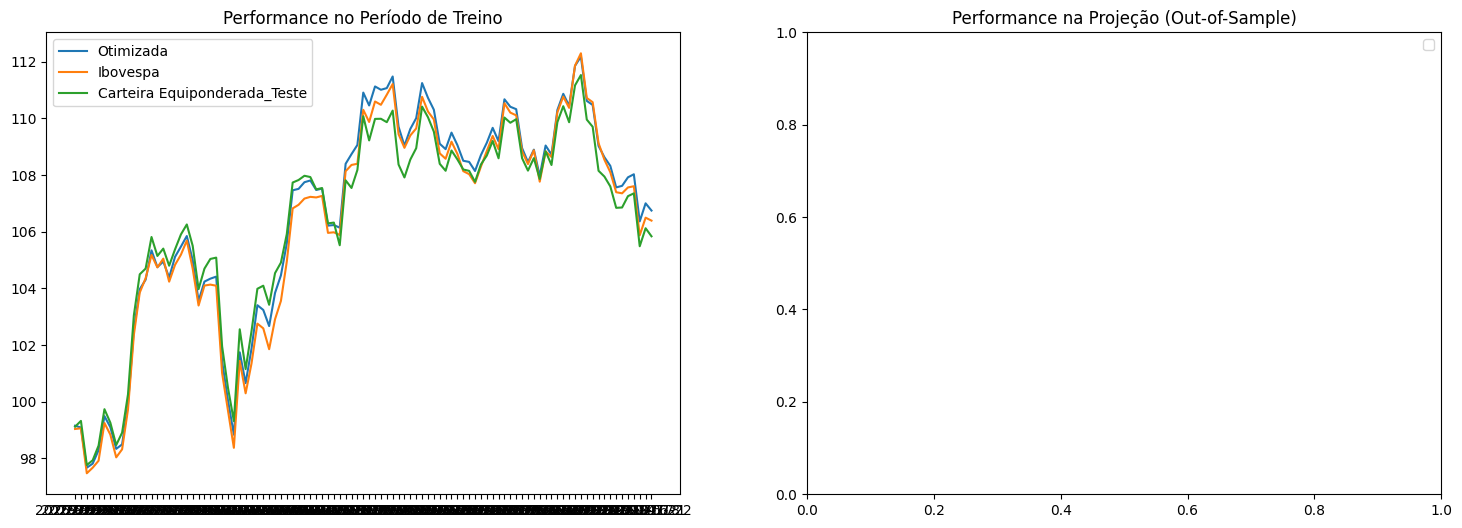

In [19]:
lsita_grande = []
for numero in range(len(retornos_ativo_treino.columns)):
    peso_ativo = pyo.value(model.x[numero])
    ativado = pyo.value(model.y[numero])
    lista = [peso_ativo, ativado]
    lsita_grande.append(lista)
    
final = pd.DataFrame(lsita_grande, columns=["peso_ativo","ativado"], index=retornos_ativo_treino.columns)
print(final[final['ativado']==1])
df_final = final[final['ativado']==1]
# df_final.head()
ativos_selecionados = df_final.index
retornos_carteira= retornos_ativo_treino[ativos_selecionados]
# retornos_carteira_projecao= retornos_ativo_projecao[ativos_selecionados]


carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi
# carteira_equi_projecao = retornos_carteira_projecao.mean(axis=1)
# carteira_equi_projecao = 1 + carteira_equi_projecao


# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
acum_equi = (carteira_equi).cumprod() * 100
acum_ibov = (1 + retornos_ibov_treino['IBOV']).cumprod() * 100

# Use os pesos que você já encontrou no modelo
# # carteira_projecao = (retornos_ativo_projecao[ativos_selecionados] * df_final["peso_ativo"]).sum(axis=1)
# acum_projecao = (1 + carteira_projecao).cumprod() * 100
# acum_equi_projecao = (carteira_equi_projecao).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])

qnt_carteira = pyo.value(model.QUANTIDADE_ATIVOS)
texto = f'Comparação de Performance: Index Tracking ({qnt_carteira} ativos)'

plt.figure(figsize=(18, 6))


# Gráfico 1: Período de Treino
plt.subplot(1, 2, 1)
plt.plot(acum_otimizado, label="Otimizada")
plt.plot(acum_ibov, label="Ibovespa")
plt.plot(acum_equi, label="Carteira Equiponderada_Teste")
plt.title("Performance no Período de Treino")
plt.legend()

# Gráfico 2: Período de Projeção (Out-of-Sample)
plt.subplot(1, 2, 2)
# plt.plot(acum_projecao, label="Otimizada (Projeção)")
# plt.plot((1 + retornos_ibov_projecao["IBOV"]).cumprod() * 100, label="Ibovespa (Projeção)")
# plt.plot(acum_equi_projecao, label="Carteira Equiponderada_Projeção")
plt.title("Performance na Projeção (Out-of-Sample)")
plt.legend()

plt.show()

### ----------------------------

## CONSTRUÇÃO DA SEGUNDA ETAPA

### ----------------------------

In [20]:
retornos_ativo_segunda_etapa = retornos_ativo_segunda_etapa[df_final.index]

In [21]:
dicio_ativos_segunda_etapa = {}
for t in range(len(retornos_ativo_segunda_etapa)):
    for a in range(len(retornos_ativo_segunda_etapa.columns)):
        dicio_ativos_segunda_etapa[t,a] = retornos_ativo_segunda_etapa.iloc[t,a]

dicio_ibov_segunda_etapa = {}
for t in range(len(retornos_ibov_segunda_etapa)):
    dicio_ibov_segunda_etapa[t] = retornos_ibov_segunda_etapa['IBOV'].iloc[t]


std_ativos_segunda_etapa = retornos_ativo_segunda_etapa.std()
std_ativos_segunda_etapa = pd.DataFrame(std_ativos_segunda_etapa, columns=['desvio_padrao'])
dicio_std_segunda_etapa = {}
for a in range(len(retornos_ativo_segunda_etapa.columns)):
    dicio_std_segunda_etapa[a] = std_ativos_segunda_etapa['desvio_padrao'].iloc[a]


#### ----- Iniciando segundo modelo

In [22]:
model_2 = pyo.ConcreteModel()

# RANGE SET
model_2.A = pyo.RangeSet(0,len(retornos_ativo_segunda_etapa.columns)-1)
model_2.T = pyo.RangeSet(0, len(retornos_ativo_segunda_etapa)-1)

# PARAMETROS----------------------
model_2.ATIVOS = pyo.Param(model_2.T,model.A, initialize=dicio_ativos_segunda_etapa)
model_2.IBOV = pyo.Param(model_2.T, initialize=dicio_ibov_segunda_etapa)
model_2.DELTA = pyo.Param(model_2.A, initialize = dicio_std_segunda_etapa)
    ##----------------- GAMA: Orçamento de Incerteza -> Defini quantos ativos podem variar ao mesmo tempo (Seguro geral)
        ##  ------ mutable = True -> define parâmetros que podem ser alterados entre execuções de otimização sem reconstruir o modelo
            ##----model.GAMA = 2.0  # Forma simples  OU model.GAMA.store(2.0)
model_2.GAMA = pyo.Param(initialize = 0.0, mutable = True)
model_2.QUANTIDADE_ATIVOS = pyo.Param(initialize = 10.0)

# VARIAVEIS----------------------
model_2.x = pyo.Var(model_2.A, bounds=(0,1))
model_2.y = pyo.Var(model_2.A, within=pyo.Binary)
    ## Para cada dia $t$, o modelo precisa de variáveis extras para "absorver" a incerteza: z[t]: Uma variável global de proteção para o dia $t$. p[t, a]: Uma variável de proteção específica para cada ativo no dia $t$.
model_2.z = pyo.Var(model_2.T, bounds=(0,None))
model_2.p = pyo.Var(model_2.T, model_2.A, bounds=(0,None))

    #Capturar erro absoluto de cada dia
model_2.erro = pyo.Var(model_2.T, bounds=(0,None))

##------------ ALTERAÇÂO DE MSE para MAD 
def erro_pos(model_2, t):
    return model_2.erro[t] >= sum(model_2.ATIVOS[t,a] * model_2.x[a] for a in model_2.A) - model_2.IBOV[t]
def erro_neg(model_2, t):
    return model_2.erro[t] >= -(sum(model_2.ATIVOS[t,a] * model_2.x[a] for a in model_2.A) - model_2.IBOV[t])

model_2.con_erro_post = pyo.Constraint(model_2.T, rule=erro_pos)
model_2.con_erro_neg = pyo.Constraint(model_2.T, rule=erro_neg)
# controle_peso_da_protecao = 0.1
controle_peso_da_protecao = 1

# OBJETIVO----------------------
def func_objetivo_1(model_2):
    mad = sum(model_2.erro[t] for t in model_2.T)
    
    ## Termo de proteção Robusta -----------
    protecao = sum(
        (model_2.GAMA * model_2.z[t] + sum(model_2.p[t,a] for a in model_2.A)) for t in model_2.T
    )

    

    return mad + controle_peso_da_protecao*protecao

model_2.obj = pyo.Objective(rule=func_objetivo_1,sense=pyo.minimize)


# RESTRICOES ----------------------
    ## - Ela diz que a proteção deve ser maior ou igual ao impacto do desvio padrão no peso do ativo
def regra_protecao(model_2,t,a):
    
    return model_2.z[t] + model_2.p[t,a] >= model_2.DELTA[a] * model_2.x[a]

model_2.con_protecao = pyo.Constraint(model_2.T,model_2.A, rule=regra_protecao)

    ## OUTRAS RESTRIÇÔES

    # 1- Cardinalidade (total ativos na carteira)
def cardinalidade(model_2):

    return sum(
        model_2.y[a] for a in model_2.A
    ) <= model_2.QUANTIDADE_ATIVOS
model_2.cardinalidade = pyo.Constraint(rule=cardinalidade)

    # 2 - Soma peso da carteira
def soma_peso_1(model_2):
    return sum(model_2.x[a] for a in model_2.A) == 1
model_2.soma_peso_1 = pyo.Constraint(rule=soma_peso_1)

    # 3 - x só ativa se y=1
def restr_vinculo_x_y(model_2, a):

    return model_2.x[a] <= model_2.y[a]

model_2.restr_vinculo_x_y = pyo.Constraint(model_2.A, rule=restr_vinculo_x_y)

    # Retrição de Peso mínimo, se y=1, x deve ser pelo menos 1%
def peso_min(model_2, a):
    return model_2.x[a] >= 0.01 * model_2.y[a]
model_2.peso_min = pyo.Constraint(model_2.A, rule=peso_min)




In [23]:
# Antes do solve, dê uma solução inicial ao CPLEX
for a in model_2.A:
    model_2.x[a].value = pyo.value(model.x[a])  # Peso igual para 20 ativos
    model_2.y[a].value = pyo.value(model.y[a])

In [24]:
opt2 = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
opt2.options['TimeLimit'] = 300 
# resultado = opt.solve(model)
# opt.options['optimalitytarget'] = 3 ## PARA CASO DE MODELOS NAO LINEARES
# opt2.options['mip tolerances absmipgap'] = 0.01 
# opt2.options['mip tolerances mipgap'] = 0.01 
# opt2.options['mipgap'] = 0.01 

results = opt2.solve(model_2, tee=True, warmstart=True)
print("-------FIM----------")



Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\DECIV\AppData\Local\Temp\tmpnxnscszb.cplex.log' open.
CPLEX> New value for time limit in seconds: 300
CPLEX> Problem 'C:\Users\DECIV\AppData\Local\Temp\tmp0lvzl5s3.pyomo.lp' read.
Read time = 0.00 sec. (0.27 ticks)
CPLEX> MIP start file 'C:\Users\DECIV\AppData\Local\Temp\tmpwlf58nn0.cplex.mst' read.
CPLEX> Problem name         : C:\Users\DECIV\AppData\Local\Temp\tmp0lvzl5s3.pyomo.lp
Objective sense      : Minimize
Variables            :    2240  [Nneg: 2200,  Box: 20,  Binary: 20]
Objective nonzeros   :    2100
Linear constraints   :    2242  [Less: 2241,  Equal: 1]
  Nonzeros        

## SEGUNDO GRAFICO

In [28]:
df_projecao_final

,IBOV
Date,
2025-12-11,0.000717
2025-12-12,0.009906
2025-12-15,0.010674
2025-12-16,-0.024027
2025-12-17,-0.007889
2025-12-18,0.003788
2025-12-19,0.003483
2025-12-22,-0.002089
2025-12-23,0.014632


          peso_ativo  ativado
VALE3.SA    0.155194      1.0
ITUB4.SA    0.202888      1.0
PETR4.SA    0.193091      1.0
AXIA3.SA    0.066203      1.0
SBSP3.SA    0.074641      1.0
B3SA3.SA    0.099561      1.0
RENT3.SA    0.055135      1.0
GGBR4.SA    0.049157      1.0
CMIG4.SA    0.064560      1.0
DIRR3.SA    0.039570      1.0
          peso_ativo  ativado
VALE3.SA    0.060270      1.0
ITUB4.SA    0.103846      1.0
PETR4.SA    0.058657      1.0
PETR3.SA    0.041075      1.0
AXIA3.SA    0.065223      1.0
SBSP3.SA    0.064740      1.0
B3SA3.SA    0.040195      1.0
WEGE3.SA    0.048145      1.0
BBAS3.SA    0.058731      1.0
ABEV3.SA    0.036522      1.0
RENT3.SA    0.039540      1.0
RADL3.SA    0.012115      1.0
BBDC3.SA    0.053261      1.0
GGBR4.SA    0.042873      1.0
CMIG4.SA    0.046076      1.0
TOTS3.SA    0.056564      1.0
SMFT3.SA    0.037714      1.0
BRAP4.SA    0.066220      1.0
DIRR3.SA    0.035263      1.0
RECV3.SA    0.032971      1.0
113.54469321728693
124.72167015470752
11

C:\Users\DECIV\AppData\Local\Temp\ipykernel_8540\3648190023.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_8540\3648190023.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_8540\3648190023.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])
C:\Users\DECIV\AppData\Local\

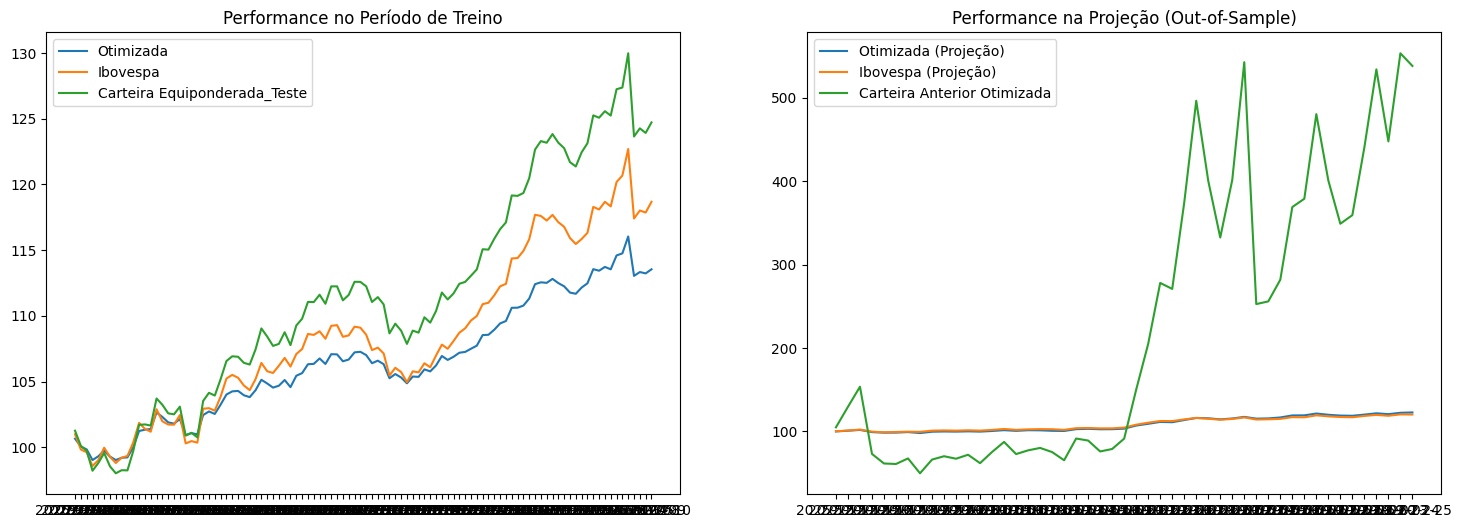

In [34]:
lsita_grande_2 = []
for numero in range(len(retornos_ativo_segunda_etapa.columns)):
    peso_ativo = pyo.value(model_2.x[numero])
    ativado = pyo.value(model_2.y[numero])
    lista = [peso_ativo, ativado]
    lsita_grande_2.append(lista)
    
final_2 = pd.DataFrame(lsita_grande_2, columns=["peso_ativo","ativado"], index=retornos_ativo_segunda_etapa.columns)
print(final_2[final_2['ativado']==1])
print(df_final)
df_final_2 = final_2[final_2['ativado']==1]
# df_final.head()
ativos_selecionados = df_final_2.index
retornos_carteira= retornos_ativo_segunda_etapa[ativos_selecionados]

retornos_carteira_projecao= df_projecao_final[ativos_selecionados]


carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_anterior_otimizada = df_projecao_final[df_final.index].sum(axis=1)
carteira_anterior_otimizada = 1 +carteira_anterior_otimizada

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi
# carteira_equi_projecao = retornos_carteira_projecao.mean(axis=1)
# carteira_equi_projecao = 1 + carteira_equi_projecao


# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
# acum_equi = (carteira_equi).cumprod() * 100
acum_anterior_otimizado = (carteira_anterior_otimizada).cumprod() * 100
acum_ibov = (1 + retornos_ibov_segunda_etapa['IBOV']).cumprod() * 100

# Use os pesos que você já encontrou no modelo
carteira_projecao = (df_projecao_final[ativos_selecionados] * df_final_2["peso_ativo"]).sum(axis=1)
acum_projecao = (1 + carteira_projecao).cumprod() * 100
# acum_equi_projecao = (carteira_equi_projecao).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])
print(acum_anterior_otimizado[-1])

qnt_carteira = pyo.value(model_2.QUANTIDADE_ATIVOS)
texto = f'Comparação de Performance: Index Tracking ({qnt_carteira} ativos)'

plt.figure(figsize=(18, 6))


# Gráfico 1: Período de Treino
plt.subplot(1, 2, 1)
plt.plot(acum_otimizado, label="Otimizada")
plt.plot(acum_ibov, label="Ibovespa")
plt.plot(acum_equi, label="Carteira Equiponderada_Teste")
plt.title("Performance no Período de Treino")
plt.legend()

# Gráfico 2: Período de Projeção (Out-of-Sample)
plt.subplot(1, 2, 2)
plt.plot(acum_projecao, label="Otimizada (Projeção)")
plt.plot((1 + df_projecao_final_ibov["IBOV"]).cumprod() * 100, label="Ibovespa (Projeção)")
plt.plot(acum_anterior_otimizado, label="Carteira Anterior Otimizada")
plt.title("Performance na Projeção (Out-of-Sample)")
plt.legend()

plt.show()